In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/rusl/Documents/salk-practicum')
from model.metrics import ssim, psnr

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from data.load import subsample
torch.cuda.set_device(4)

nb_name = 'lyndsey_model'
data_pth = Path('/home/rusl/Dropbox/BPHO Staff/USF/Segmented EM data from Lyndsey/cropped_all')
model_path = Path('/home/rusl/Documents/salk-practicum/lab/judge/')

## Data loading

In [3]:
def get_src(data_pth, stride=3):

    def map_to_target(x, return_fn=True):
        # look for the index of the original image
        s = str(x)
        i1 = s.index('.')
        i2 = s.index('_p')
        fi = int(s[i1+1:i2])
        fn = Path(f'{s[:i1+1]}{fi+stride}{s[i2:]}')
        if return_fn:
            return fn
        return fn.exists()

    print(data_pth)
    src = (ImageImageList
            .from_folder(data_pth)
            .filter_by_func(lambda fname: map_to_target(fname, return_fn=False))
            .split_subsets(train_size=0.95, valid_size=0.05)
            .label_from_func(map_to_target))
    return src

def get_data(data_pth, bs, stride=3, num_workers=4):
    src = get_src(data_pth, stride=stride)
    data = (src
#             .transform(tfms)
#             .transform_y(tfms)
            .databunch(bs=bs, num_workers=num_workers)
            .normalize(imagenet_stats, do_y=True))
#     data.c = 3
    return data

def subsample(data, pct=0.1):
    """Takes a databunch as input and returns a mini-version of the dataset
    This is useful for debugging and rapid experimentation. 
    data -> a databunch object
    pct  -> the fraction of original dataset size (default: 0.2)"""
    trn_size = len(data.train_ds)
    trn_indices = np.random.choice(np.arange(trn_size), 
                                   size=int(pct*trn_size), replace=False)
    trn_sampler = torch.utils.data.sampler.SubsetRandomSampler(trn_indices)
    val_size = len(data.valid_ds)
    val_indices = np.random.choice(np.arange(val_size), size=int(pct*val_size), replace=False)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
    data.train_dl = data.train_dl.new(shuffle=False, sampler=trn_sampler)
    data.valid_dl = data.valid_dl.new(shuffle=False, sampler=val_sampler)
    return data

In [4]:
db = get_data(data_pth, bs=20, stride=1)
# sub_db = subsample(db)

/home/rusl/Dropbox/BPHO Staff/USF/Segmented EM data from Lyndsey/cropped_all


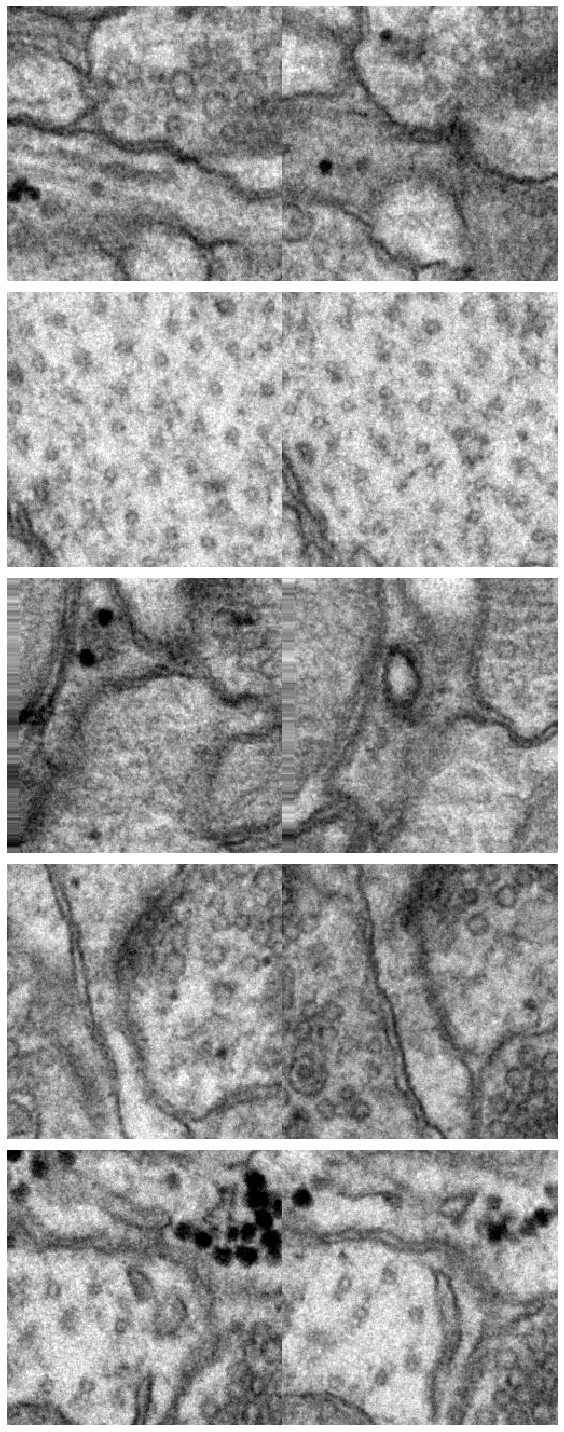

In [5]:
db.show_batch()

## Model

In [6]:
arch = models.resnet34
wd = 1e-3
superres_metrics = [F.mse_loss, ssim, psnr]
learn = unet_learner(db, arch, 
                     wd=wd, 
                     #loss_func=feat_loss,
                     loss_func=F.mse_loss,
                     metrics=F.mse_loss, 
                     #callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

21185

In [7]:
learn.data

ImageDataBunch;

Train: LabelList (94118 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/rusl/Dropbox/BPHO Staff/USF/Segmented EM data from Lyndsey/cropped_all;

Valid: LabelList (4953 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/rusl/Dropbox/BPHO Staff/USF/Segmented EM data from Lyndsey/cropped_all;

Test: None

In [8]:
learn.load(f'{nb_name}_FPNCT_5')

Learner(data=ImageDataBunch;

Train: LabelList (94118 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/rusl/Dropbox/BPHO Staff/USF/Segmented EM data from Lyndsey/cropped_all;

Valid: LabelList (4953 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/rusl/Dropbox/BPHO Staff/USF/Segmented EM data from Lyndsey/cropped_all;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplac

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


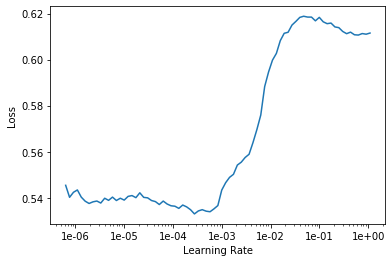

In [9]:
learn.unfreeze()

learn.lr_find()

learn.recorder.plot()

In [12]:
lr = 1e-4

In [11]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=2, imgsize=5)

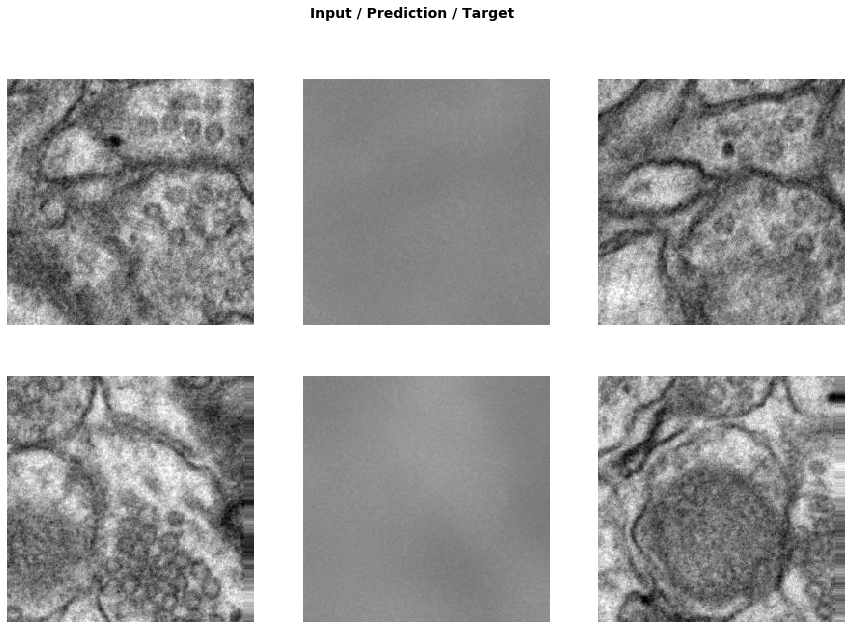

In [13]:
# the first model used stride = 3
# the second model used stride = 1
# 3rd: stride=1, cycle_len=5, no loaded model
# 4: lr = 4e-5, cycle_len=5. best for now
# 5: lr = 1e-5, cycle_len=5, loaded 4
# 6: lr = 1e-4, cycle_len=1, loaded 5
do_fit(f'{nb_name}_FPNCT_6', lr, cycle_len=1)

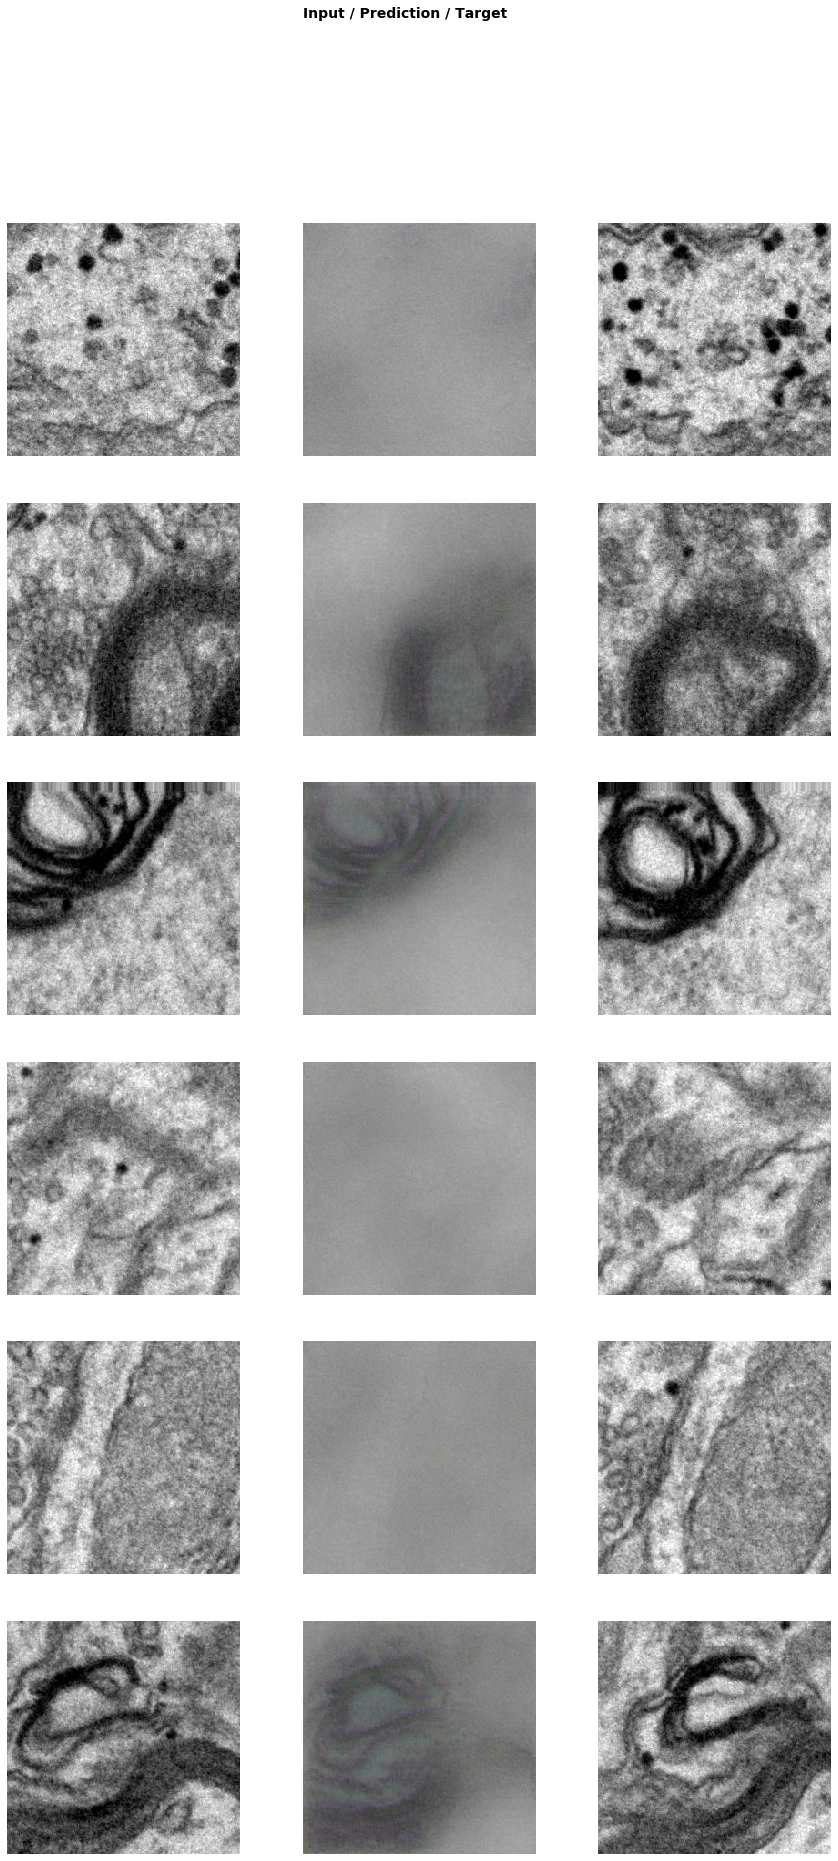

In [19]:
# model 5
learn.show_results(rows=6, imgsize=5)

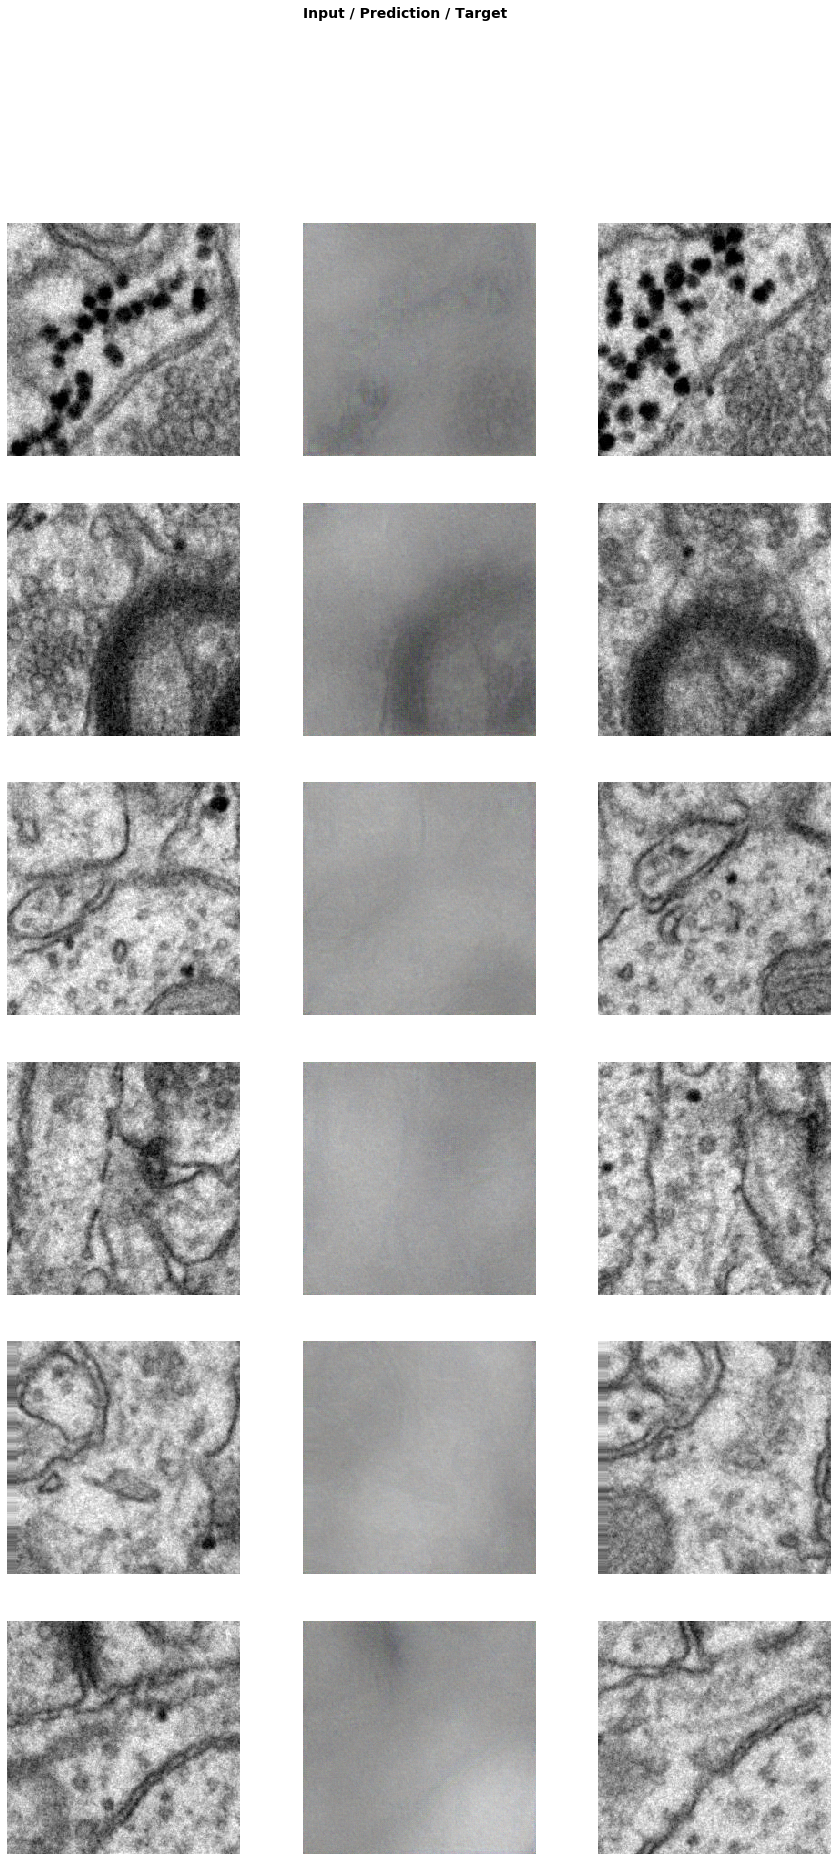

In [12]:
# model 4
learn.show_results(rows=6, imgsize=5)

In [ ]:
models.resnet34()